In [14]:
import sklearn as sk
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
import seaborn as sns
import scipy.stats as stats
import h2o
from h2o.automl import H2OAutoML

##Definition des chemins vers les differentes donnees de la dataset, departager entre celle d'entrainement, d'evalution et de test

In [15]:
flow_train_path = '/home/godwill/Documents/ovs/OVS/features/train/'

flow_test_path = '/home/godwill/Documents/ovs/OVS/features/test/'

flow_eval_path = '/home/godwill/Documents/ovs/OVS/features/evaluate/'

cpu_test_path = '/home/godwill/Documents/ovs/OVS/cpu/test/'

cpu_train_path = '/home/godwill/Documents/ovs/OVS/cpu/train/'

cpu_eval_path = '/home/godwill/Documents/ovs/OVS/cpu/evaluate/'

train_flow = glob.glob(os.path.join(flow_train_path,"*.csv"))

train_cpu = glob.glob(os.path.join(cpu_train_path , "*.txt"))

test_flow = glob.glob(os.path.join(flow_test_path , "*.csv"))

test_cpu = glob.glob(os.path.join(cpu_test_path , "*.txt"))

eval_flow = glob.glob(os.path.join(flow_eval_path,"*.csv"))

eval_cpu = glob.glob(os.path.join(cpu_eval_path , "*.txt"))

##Chargerment de nos datasets dans les differentes variables : d'entrainement, de test et d'evaluation pour cpu et pour le traffic

In [16]:
flow = pd.concat((pd.read_csv(f ,sep=' ',header=0) for f in train_flow), axis=0, ignore_index=True)

cpu = pd.concat((pd.read_csv(f, sep=' ',header=None) for f in train_cpu), axis=0, ignore_index=True)

testflow = pd.concat((pd.read_csv(f,sep=' ',header=0) for f in test_flow), axis=0, ignore_index=True)

testcpu = pd.concat((pd.read_csv(f, sep=' ',header=None) for f in test_cpu), axis=0, ignore_index=True)

evalflow = pd.concat((pd.read_csv(f,sep=' ',header=0) for f in eval_flow), axis=0, ignore_index=True)

evalcpu = pd.concat((pd.read_csv(f, sep=' ',header=None) for f in eval_cpu), axis=0, ignore_index=True)

#os.chdir('/home/godwill/Documents/ovs/OVS') #cpu = pd.read_csv('cpu/longIn0.txt', sep=' ',header=None) #flow = pd.read_csv('features/longIn_m_0.025_i_20.0.csv', sep=' ',header=0) #testcpu = pd.read_csv('cpu/longIn1.txt', sep=' ',header=None) #testflow = pd.read_csv('features/longIn1_m_0.025_i_20.0.csv', sep=' ',header=0)

###Selection des donnees cpu et du feature "nombres des packets" du traffic afin d'etablir une correlation entre cette derniere et la consommation au niveau cpu grace a un graph 

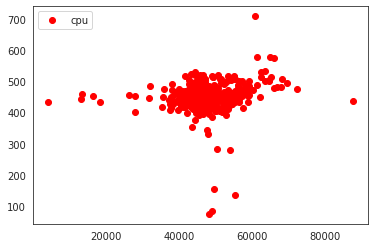

In [41]:

X2 = cpu.iloc[:]
X3 = flow.iloc[:,2]

plt.plot(X3, X2,'ro')
plt.legend(['cpu', 'flow'], loc='upper left')
#plt.xlim([1000,20000])
#plt.ylim([10,800])
#plt.show()


In [18]:
##########################Selection du flow d'entrainenemt###############################
X1= flow.iloc[:,:]

###########Creation de la dataframe##########

df = pd.DataFrame(X1)

#############Ajout de la colonne cpu dans notre dataframe###############

df["cpu"] = X2

##############Retirer la colonne "auxFet" contenant des cellules vides############

df = df.drop(columns=['auxFet'])

##############Instanciation de notre Dataframe contenant tout les feature d'entrainement######

X = df

################Recuperation des donnees cpu et traffic pour la partie test#############

X2_test = testcpu.iloc[:]

X1_test = testflow.iloc[:,:]

############Creation de la dataframe de test en ajoutant la colonne recuperant le information de consommation cpu###

dtest = pd.DataFrame(X1_test)

dtest["cpu"] = X2_test 

###########Suppression de la colonne vide "auxFet"###############

dtest = dtest.drop(columns=['auxFet'])

##############Instanciation de la dataframe X de test############

X_test = dtest

########################################## Recuperation des donnees cpu et traffic d'evalution ##############

X1_eval = evalflow.iloc[:285,:]

#########Creation de la dataframe############

deval = pd.DataFrame(X1_eval)

X2_eval = evalcpu.iloc[:]

#################Ajout de la colonne cpu d'evalution a la dataframe############

deval["cpu"] = X2_eval

#######################Suppression de la colonne vide presente dans notre dataframe############

deval = deval.drop(columns=['auxFet'])

Xeval = deval

####################Creation d'un tableau multidimensionnnel equivalente a notre dataframe

X_eval = np.array(Xeval)

df

,%batchNum,lastTS,numPackets,totalBytes,avgInterAT,stdInterAT,avgLength,stdLength,ipSrc,ipDst,...,avgLengthFlowOther,stdLengthFlowOther,onePacketFlows,httpPackets,httpFlows,sslPackets,sslFlows,smtpPackets,smtpFlows,cpu
0,1,500021,49218,19921971,10.166240,11.233076,408.505813,621.373719,1055,3461,...,4606.297495,3043,31192,3024,932,72,81,33,0,514
1,2,1000008,50552,20145083,9.898351,11.026954,401.111242,614.899779,1094,3240,...,4564.531104,2828,32815,2949,1086,80,77,16,0,521
2,3,1500014,51429,18416962,9.732037,10.840262,360.898240,593.839065,1070,3186,...,18652.900356,2743,34802,2774,138,88,142,20,0,496
3,4,2000006,51361,19495071,9.744811,10.848904,382.008034,606.901408,1068,3158,...,17583.893640,2742,34770,2875,113,69,96,27,0,508
4,5,2500010,51339,19596670,9.748728,10.821981,384.542345,605.890665,1053,3208,...,19670.617652,2638,34612,2853,133,72,86,16,0,507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,43,21500024,50826,41696681,9.847519,12.407911,826.962140,673.511716,3409,1824,...,637.969615,3846,32353,3572,430,83,78,12,0,407
464,44,22000003,52485,41157372,9.534350,11.988245,790.675126,683.147535,3388,3975,...,325.607411,6007,33764,5123,413,83,85,16,0,412
465,45,22500026,50205,40577998,9.965881,12.788786,816.419532,677.119268,3383,1456,...,425.104765,3412,33155,2979,462,78,94,14,0,421
466,46,23000017,48029,38047234,10.417467,12.697935,798.531198,676.550186,3343,1182,...,615.111778,3115,31180,2807,401,72,58,21,0,429


In [19]:
##################### Calcul de la moyenne des valeurs liees a la consommation cpu ############
df_cpu_mean = df["cpu"].mean()
df_cpu_mean

448.5705128205128

In [20]:
##################Creation de notre label binaire liee au resultat de chaque traffic et de la comsommation de notre cpu ############
######### Variable Y est une liste qui contiendra les resultats liee a la consommation cpu pour notre dataframe Train. ########################
############ Cas valables sont pour les valeurs inferieures a 450 et non valables superieur a 450###############
Y = []

for i in df["cpu"]:
    if i<450:
        Y.append(1)
    else:
        Y.append(0)
        

#df["result"] = Y
train = df
train["label"] = Y

###################### Conversion de la liste en un tableau, Y pour l'entrainement de notre model

Y = np.array(Y)



##############################################################

######### Variable Y est une liste qui contiendra les resultats liee a la consommation cpu pour notre dataframe Test. ########################
############ Cas valables sont pour les valeurs inferieures a 450 et non valables superieur a 450###############

Ytest = []

for i in dtest["cpu"]:
    if i<450:
        Ytest.append(1)
    else:
        Ytest.append(0)
        
test = dtest

###################### Conversion de la liste en un tableau, Y pour le Test de notre model
        
Y_test=np.array(Ytest)

##########################################################################


Yeval = []

for i in deval["cpu"]:
    if i<450:
        Yeval.append(1)
    else:
        Yeval.append(0)
        
#################### Conversion de la liste en un tableau, Y pour l'evalution de notre model #################
        
Y_eval=np.array(Yeval)


Y_eval.size


285

In [21]:
######################### Entrainement de notre model SVM

SVM = svm.LinearSVC()

SVM.fit(X.iloc[:,:88],Y)


####################### Evalution de notre model : Affichage du Score de notre model SVM

#print(round(SVM.score(X_eval, Y_eval), 4))

predicted_y = SVM.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test, predicted_y).ravel()
precision_score = tp / (tp + fp)
recall_score = tp / (tp + fn)
print(recall_score)
precision_score

0.4656084656084656


/home/godwill/notebook/jupyterenv/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


0.39111111111111113

/home/godwill/notebook/jupyterenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<AxesSubplot:>

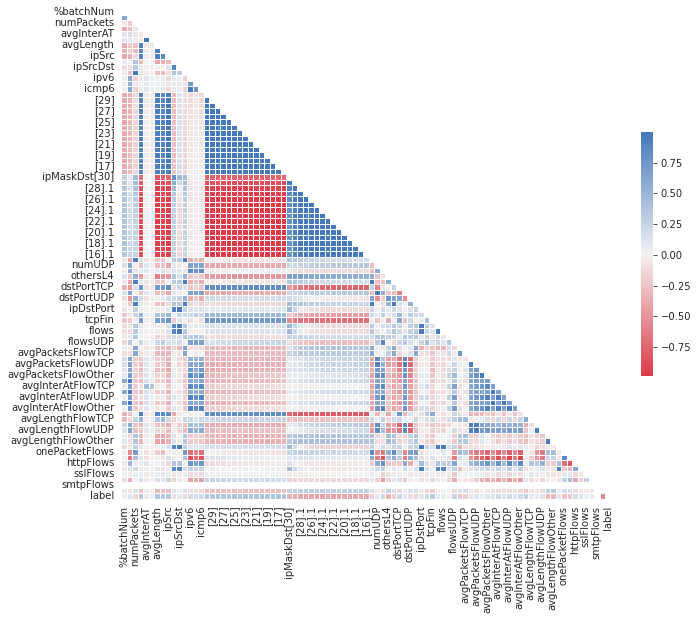

In [22]:
# use the pands .corr() function to compute pairwise correlations for the dataframe
corr = train.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
#df.corr()
#plt.figure(figsize=(24,14))
#sns.heatmap(df.corr(), annot=True, cmap='viridis')
#plt.ylim(10, 0)

In [23]:
###################### Test de la model ######################

SVM.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [24]:
######################### Entrainement de notre model Logistic Regression #######################


pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X, Y)  # apply scaling on training data

pipe.score(X_test, Y_test)


/home/godwill/notebook/jupyterenv/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- label

  warnings.warn(message, FutureWarning)


ValueError: X has 88 features, but StandardScaler is expecting 89 features as input.

In [25]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Training and validation loss curve')
#plt.ylabel('cpu')
#plt.xlabel('flow')
#plt.legend(['Training','validation'], loc='upper right')
#plt.show()

In [26]:
######################## Evaluation de notre model######################## 
pipe.score(X_eval, Y_eval)


/home/godwill/notebook/jupyterenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


ValueError: X has 88 features, but StandardScaler is expecting 89 features as input.

In [27]:
########################### Predication avec nos donnees de test ##########################

pipe.predict(X_test)

/home/godwill/notebook/jupyterenv/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- label

  warnings.warn(message, FutureWarning)


ValueError: X has 88 features, but StandardScaler is expecting 89 features as input.

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
from numpy import where

In [29]:
############################### Decsion tree algorithm test ###############################

params = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'splitter': ['best', 'random']
}

clf = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=4,
    n_jobs=5,
    verbose=1,
)



#clf = DecisionTreeClassifier()
clf.fit(X.iloc[:,:88], Y)

############################ Prediction de la model ##########

predictions = clf.predict(X_test)

print(predictions[:])


y_pred = clf.predict(X_test)
y_score = clf.score(X_test, Y_test)
print('Accuracy: ', y_score)

# Compute the average precision score

micro_precision = precision_score(y_pred, Y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, Y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, Y_test, average=None)
print('Per-class precision score:', per_class_precision)

################################### Evaluation de la model ###########





print(accuracy_score(Y_test, predictions))

Fitting 4 folds for each of 168 candidates, totalling 672 fits
[1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0
 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
Accuracy:  1.0
Micro-averaged precision score: 1

print(X.shape, Y.shape)
# summarize observations by class label
counter = Counter(Y)
print(counter)
# summarize first few examples
for i in range(10):
	print(X[i], Y[i])
# plot the dataset and color the by class label
for label, _ in counter.items():
	row_ix = where(Y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [30]:
h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.22.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.22.04.1, mixed mode, sharing)
  Starting server from /home/godwill/notebook/jupyterenv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnp5v1xl3
  JVM stdout: /tmp/tmpnp5v1xl3/h2o_godwill_started_from_python.out
  JVM stderr: /tmp/tmpnp5v1xl3/h2o_godwill_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Africa/Lubumbashi
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.4
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_godwill_8c393k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [31]:
trained = h2o.H2OFrame(train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
train_as_df = h2o.as_list(trained)
train_as_df = train_as_df[train_as_df['label'].notna()]
train_as_df = train_as_df[train_as_df['cpu'].notna()]
train_as_df = train_as_df[train_as_df['numPackets'].notna()]
train_as_df = train_as_df[train_as_df['totalBytes'].notna()]
train_as_df = train_as_df[train_as_df['numTCP'].notna()]
train_as_df = train_as_df[train_as_df['numUDP'].notna()]
train_as_df = train_as_df[train_as_df['flows'].notna()]
train_as_df = train_as_df[train_as_df['flowsTCP'].notna()]
train_as_df = train_as_df[train_as_df['flowsUDP'].notna()]
train_as_df = train_as_df[train_as_df['flowsOther'].notna()]
train_as_df = train_as_df[train_as_df['avgPacketsFlowTCP'].notna()]
train_as_df = train_as_df[train_as_df['avgPacketsFlowUDP'].notna()]
train_as_df = train_as_df[train_as_df['avgPacketsFlowOther'].notna()]
train_as_df = train_as_df[train_as_df['avgLengthFlowTCP'].notna()]
train_as_df = train_as_df[train_as_df['avgLengthFlowOther'].notna()]
train_as_df = train_as_df[train_as_df['onePacketFlows'].notna()]
#train_as_df = train_as_df[train_as_df['label'].notna()]


In [15]:
round((train_as_df.isnull().sum() * 100/ len(train_as_df)),2).sort_values(ascending=False)


%batchNum            0.0
numTCP               0.0
stdPacketsFlowUDP    0.0
avgPacketsFlowUDP    0.0
stdPacketsFlowTCP    0.0
                    ... 
[17]                 0.0
[18]                 0.0
[19]                 0.0
[20]                 0.0
label                0.0
Length: 89, dtype: float64

In [16]:
train = h2o.H2OFrame(train_as_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
x = train.columns
y = "label"
x.remove(y)

In [18]:
aml = H2OAutoML(max_models=10, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
18:12:21.998: _train param, Dropping bad and constant columns: [smtpFlows]
18:12:21.998: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.


18:12:23.619: _train param, Dropping bad and constant columns: [smtpFlows]
18:12:23.619: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
18:12:24.299: _train param, Dropping bad and constant columns: [smtpFlows]
18:12:24.299: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

███
18:12:28.788: _train param, Dropping bad and const

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,267.0,267.0,24480.0,1.0,3.0,1.561798,2.0,4.0,2.561798




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.00010397505613138362
RMSE: 0.010196815980068661
MAE: 0.007435913036474669
RMSLE: 0.006735705161543834
Mean Residual Deviance: 0.00010397505613138362

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 2.808910492761692e-05
RMSE: 0.005299915558536468
MAE: 0.0034778785873401767
RMSLE: 0.004246689992590817
Mean Residual Deviance: 2.808910492761692e-05

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.003477,0.000561,0.003004,0.004181,0.003739,0.002811,0.003648
1,mean_residual_deviance,0.000028,0.000012,0.000024,0.000034,0.000024,0.000014,0.000045
2,mse,0.000028,0.000012,0.000024,0.000034,0.000024,0.000014,0.000045
3,r2,0.999887,0.000048,0.999905,0.999864,0.999903,0.999944,0.999819
4,residual_deviance,0.000028,0.000012,0.000024,0.000034,0.000024,0.000014,0.000045
5,rmse,0.005205,0.001120,0.004874,0.005818,0.004912,0.003719,0.006701
6,rmsle,0.004166,0.000915,0.004436,0.004811,0.003981,0.002669,0.004933



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-08-06 18:12:27,3.176 sec,0.0,0.499836,0.499671,0.249836
1,,2022-08-06 18:12:27,3.260 sec,5.0,0.342895,0.341363,0.117577
2,,2022-08-06 18:12:27,3.328 sec,10.0,0.204082,0.201653,0.041650
3,,2022-08-06 18:12:27,3.381 sec,15.0,0.153868,0.146212,0.023675
4,,2022-08-06 18:12:27,3.418 sec,20.0,0.106003,0.094139,0.011237
5,,2022-08-06 18:12:27,3.457 sec,25.0,0.079448,0.062095,0.006312
6,,2022-08-06 18:12:27,3.496 sec,30.0,0.066198,0.048344,0.004382
7,,2022-08-06 18:12:27,3.537 sec,35.0,0.057534,0.041837,0.003310
8,,2022-08-06 18:12:27,3.583 sec,40.0,0.051438,0.037851,0.002646
9,,2022-08-06 18:12:27,3.631 sec,45.0,0.047090,0.034952,0.002217



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,cpu,569.197998,1.000000,0.932721
1,[20].1,30.099323,0.052880,0.049322
2,[28].1,3.626318,0.006371,0.005942
3,[18].1,2.542632,0.004467,0.004167
4,avgPacketsFlowUDP,1.110470,0.001951,0.001820
5,totalBytes,0.677013,0.001189,0.001109
6,stdInterAtFlowTCP,0.466810,0.000820,0.000765
7,ipMaskDst[30],0.359789,0.000632,0.000590
8,tcpRes,0.330737,0.000581,0.000542
9,[16].1,0.264932,0.000465,0.000434



See the whole table with table.as_data_frame()


In [19]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_1_AutoML_1_20220806_181221,0.00529992,2.80891e-05,0.00347788,0.00424669,2.80891e-05
StackedEnsemble_AllModels_1_AutoML_1_20220806_181221,0.00634144,4.02139e-05,0.004666,0.00488287,4.02139e-05
StackedEnsemble_BestOfFamily_1_AutoML_1_20220806_181221,0.00668465,4.46845e-05,0.00464219,0.00518938,4.46845e-05
GBM_4_AutoML_1_20220806_181221,0.0117087,0.000137093,0.00799145,0.00907635,0.000137093
XGBoost_2_AutoML_1_20220806_181221,0.0234643,0.000550575,0.0140227,0.0173845,0.000550575
GBM_3_AutoML_1_20220806_181221,0.044095,0.00194437,0.0280942,0.0332477,0.00194437
GBM_2_AutoML_1_20220806_181221,0.0461014,0.00212534,0.031156,0.0343124,0.00212534
XGBoost_3_AutoML_1_20220806_181221,0.0587906,0.00345633,0.038817,0.0441909,0.00345633
DRF_1_AutoML_1_20220806_181221,0.0636221,0.00404777,0.037735,0.0465838,0.00404777
XGBoost_1_AutoML_1_20220806_181221,0.0655931,0.00430246,0.040847,0.0496344,0.00430246


In [20]:
trained = h2o.H2OFrame(test)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
preds = aml.predict(trained)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [22]:
dfr = trained.cbind(preds)
dfr

%batchNum,lastTS,numPackets,totalBytes,avgInterAT,stdInterAT,avgLength,stdLength,ipSrc,ipDst,ipSrcDst,ipv4,ipv6,icmp4,icmp6,ipMaskSrc[30],[29],[28],[27],[26],[25],[24],[23],[22],[21],[20],[19],[18],[17],[16],ipMaskDst[30],[29].1,[28].1,[27].1,[26].1,[25].1,[24].1,[23].1,[22].1,[21].1,[20].1,[19].1,[18].1,[17].1,[16].1,numTCP,numUDP,Unnamed: 47,othersL4,srcPortTCP,dstPortTCP,srcPortUDP,dstPortUDP,ipSrcPort,ipDstPort,tcpSyn,tcpFin,tcpRes,flows,flowsTCP,flowsUDP,flowsOther,avgPacketsFlowTCP,stdPacketsFlowTCP,avgPacketsFlowUDP,stdPacketsFlowUDP,avgPacketsFlowOther,stdPacketsFlowOther,avgInterAtFlowTCP,stdInterAtFlowTCP,avgInterAtFlowUDP,stdInterAtFlowUDP,avgInterAtFlowOther,stdInterAtFlowOther,avgLengthFlowTCP,stdLengthFlowTCP,avgLengthFlowUDP,stdLengthFlowUDP,avgLengthFlowOther,stdLengthFlowOther,onePacketFlows,httpPackets,httpFlows,sslPackets,sslFlows,smtpPackets,smtpFlows,cpu,predict
1,500001,52883,2.18645e+07,9.46019,10.6502,416.831,626.024,1029,3091,4104,52792,91,112,91,923,827,699,547,402,268,169,102,57,32,18,11,7,4,3,2969,2906,2837,2750,2679,2612,2547,2489,2433,2370,2296,2216,2114,1972,1798,45627,6612,441,2980,45627,440,6612,4223,52793,659,418,87,5285,3940,952,393,11.5805,58.1877,6.94538,19.6012,1.63868,5.0612,192230,149768,204093,154589,247888,150310,4375.41,39639.5,4843.06,22263.1,108.5,294.629,2544,35180,2687,189,91,293,25,0,411,0.974027
2,1.00001e+06,50816,1.99594e+07,9.84687,11.0458,395.893,613.276,1035,3132,4179,50784,32,112,32,914,816,693,543,391,260,166,102,57,32,18,11,7,4,3,2996,2930,2848,2759,2693,2634,2581,2531,2486,2437,2367,2287,2176,2035,1869,43803,6429,440,2954,43803,473,6429,4227,50785,697,490,98,5384,3959,1004,421,11.0642,50.3937,6.40339,19.0248,1.38717,2.83304,694478,150181,706790,150398,751517,143369,3957.77,35970,4262.94,20523.5,80.6471,147.348,2723,33757,2698,207,95,468,37,0,411,0.993824
3,1.5e+06,48422,1.67605e+07,10.3298,11.3423,349.574,588.858,1014,3063,4048,48361,61,127,61,904,802,676,529,399,270,170,102,57,32,18,11,7,4,3,2944,2878,2799,2695,2617,2560,2496,2446,2394,2336,2258,2186,2088,1954,1781,40815,6929,490,2838,40814,480,6929,4142,48361,564,380,116,5252,3763,1032,457,10.8464,54.0617,6.71415,20.7233,1.48359,3.74604,1.19317e+06,152542,1.20836e+06,150468,1.24487e+06,141427,3205,29618.4,4547.24,23218.2,83.1203,126.555,2704,31612,2596,199,86,287,31,0,398,0.975311
4,2.00001e+06,48731,1.64212e+07,10.2653,11.1395,339.824,578.917,1027,3230,4296,48635,96,158,93,917,819,695,542,397,269,170,103,57,32,18,11,7,4,3,3095,3035,2948,2848,2779,2718,2656,2606,2550,2493,2416,2343,2222,2066,1885,41652,6443,385,3085,41649,545,6440,4437,48636,768,462,160,5514,4032,1079,403,10.3304,46.6775,5.97127,19.1184,1.57816,4.73019,1.69189e+06,148748,1.6938e+06,148527,1.7413e+06,147113,2931.03,25971.8,4257.98,24013.5,89.0435,163.803,2782,31791,2821,196,84,353,37,0,433,0.960529
5,2.5e+06,48456,1.75262e+07,10.3208,11.3724,365.041,598.299,1043,3060,4125,48350,106,119,60,937,825,692,549,401,266,169,101,57,32,18,11,7,4,3,2932,2864,2795,2709,2635,2564,2510,2456,2408,2354,2285,2197,2090,1948,1770,41471,6388,418,2906,41425,464,6387,4166,48351,706,312,135,5258,3883,947,428,10.6801,47.8004,6.74551,21.4932,1.39486,3.0433,2.18984e+06,151104,2.20962e+06,154493,2.23357e+06,142525,3334.98,26202.8,4821.47,25853,103.46,224.564,2616,31613,2597,221,98,436,31,0,438,0.978594
6,3.00001e+06,47558,1.88359e+07,10.5188,11.5068,401.134,610.731,1068,3296,4357,47355,203,88,29,953,843,700,543,399,263,167,101,57,31,18,11,7,4,3,3177,3108,3038,2947,2866,2794,2741,2686,2633,2571,2495,2397,2284,2118,1934,39476,7496,469,3065,39302,566,7495,4468,47356,786,394,82,5638,4039,1139,460,9.77371,44.5323,6.58121,22.9162,1.27391,1.75759,2.69142e+06,149564,2.71407e+06,153272,2.72303e+06,152352,3385.12,29791.2,4526.22,27255.3,104.13,221.464,2948,29675,2785,241,110,476,29,0,438,0.973217
7,3.5e+06,51207,1.9974e+07,9.76903,10.8657,393.686,610.459,1093,3227,4333,51144,63,100,63,981,870,720,568,407,270,170,103,57,32,18,11,7,4,3,3098,3025,2945,2850,2767,2682,2617,2568,2519,2450,2371,

In [29]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])

In [30]:
metalearner = h2o.get_model(se.metalearner()['name'])

/home/godwill/notebook/jupyterenv/lib/python3.7/site-packages/h2o/estimators/stackedensemble.py:929: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  H2ODeprecationWarning


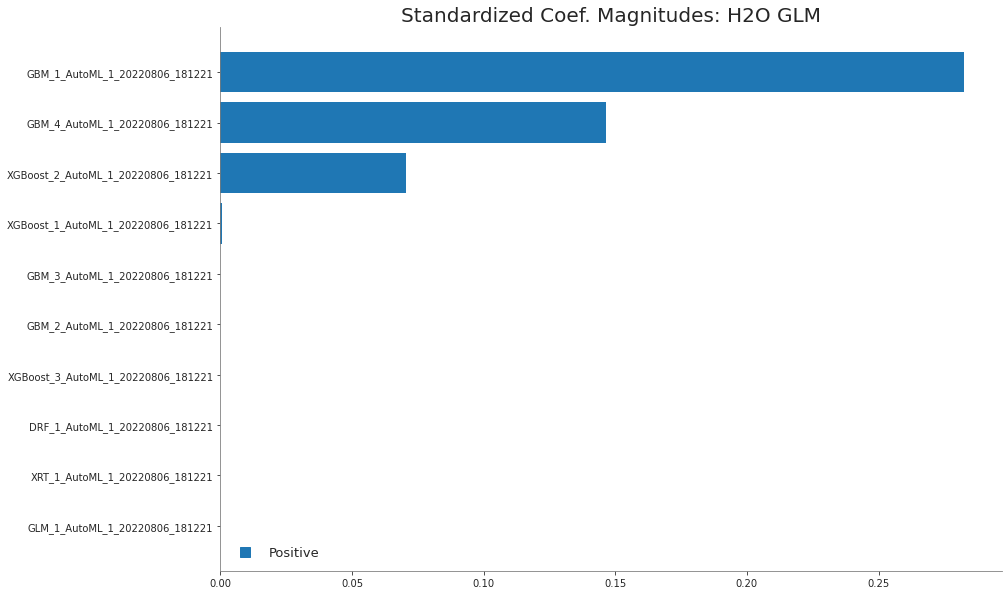

In [32]:
%matplotlib inline
metalearner.std_coef_plot()